<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/6_BatchNormalization_Regularization/Experiments/BatchNorm/BN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
from itertools import product

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [2]:
class Net(nn.Module):
    def __init__(self,norm_type='BN',dropout_value = 0.01):
        super(Net, self).__init__()
        self.conv1 = self.conv2d(1, 8, 3,norm_type,dropout_value,2)
        self.conv2 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        
        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        
        self.conv3 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        self.conv4 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.conv5 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)
        self.conv6 =  self.conv2d(16, 16, 1,norm_type,dropout_value,4) 
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 

    def conv2d(self, in_channels, out_channels, kernel_size, norm_type, dropout,num_of_groups):
        if norm_type == "BN":
         conv = nn.Sequential(OrderedDict([
                ('conv2d', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('BatchNorm',nn.BatchNorm2d(out_channels)),
                ('Dropout', nn.Dropout(dropout))
         ]))
        elif norm_type == "LN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ## When number of groups is 1, its layernorm
                ('LayerNorm',nn.GroupNorm(1,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        elif norm_type == "GN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('GroupNorm',nn.GroupNorm(num_of_groups,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        else:
            conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
      
        return conv

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('BN',0.01).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [7]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    


In [8]:

def test(model, device, test_loader,test_acc,test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))




In [9]:
def experiments(train_loader, test_loader, norm_type, l1_factor, l2_factor, dropout, epochs, batchSize):
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
  
    model = Net(norm_type, dropout).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7,weight_decay=l2_factor)
    scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=epochs,steps_per_epoch=len(train_loader))
    epochs = epochs

    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}:')
      train(model, device, train_loader, optimizer, epoch, train_accuracy, train_losses, l1_factor,scheduler)
      test(model, device, test_loader,test_accuracy,test_losses)

    return (train_accuracy,train_losses,test_accuracy,test_losses),model

In [10]:
'''exp = {  
    'BatchNorm':[]
    'BatchNorm+L1':['BN',0.002,0]
}'''
parameters = dict(
    batch_size = [64,128]
    ,l1 = [0, .001, .002]
    ,l2 = [0, .001, .002]
)

param_values = [v for v in parameters.values()]

for batch_size, l1, l2 in product(*param_values): 
  exp_metrics = {}
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
  test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)
  print('\n' +'\033[1m' + '=====================================Model Training for batch size:  ' + str(batch_size) + ',l1:  '+ str(l1) + ',l2: '+str(l2) +'======================================================'+'\033[0m\n')
  (exp_metrics['BN']),model = experiments(train_loader, test_loader,'BN',l1,l2,0.03,20,batch_size)
  torch.save(model, './{}.pt'.format('BN_'+str(batch_size) + 'l1_'+ str(l1) + ',l2_'+str(l2)))

'''for e in exp.items():
  print('\n' +'\033[1m' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\033[0m\n')
  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)
  torch.save(model, './{}.pt'.format(e[0]))'''

  0%|          | 0/938 [00:00<?, ?it/s]


=====================================Model Training for batch size:  64,l1:  0,l2: 0======================================================

Epoch 1:


Loss=0.3136543333530426 Batch_id=937 Accuracy=75.33: 100%|██████████| 938/938 [00:33<00:00, 27.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1602, Accuracy: 9563/10000 (95.63%)

Epoch 2:


Loss=0.11508646607398987 Batch_id=937 Accuracy=94.10: 100%|██████████| 938/938 [00:34<00:00, 27.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9835/10000 (98.35%)

Epoch 3:


Loss=0.1591918170452118 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [00:34<00:00, 26.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9864/10000 (98.64%)

Epoch 4:


Loss=0.012699670158326626 Batch_id=937 Accuracy=96.64: 100%|██████████| 938/938 [00:34<00:00, 27.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

Epoch 5:


Loss=0.12059184163808823 Batch_id=937 Accuracy=96.97: 100%|██████████| 938/938 [00:34<00:00, 27.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

Epoch 6:


Loss=0.09739039093255997 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:34<00:00, 27.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

Epoch 7:


Loss=0.09538368880748749 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:34<00:00, 27.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

Epoch 8:


Loss=0.07803705334663391 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:34<00:00, 27.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

Epoch 9:


Loss=0.1820959895849228 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:34<00:00, 27.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

Epoch 10:


Loss=0.08153152465820312 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:34<00:00, 27.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

Epoch 11:


Loss=0.0917786955833435 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:34<00:00, 27.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)

Epoch 12:


Loss=0.058343809098005295 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:34<00:00, 27.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

Epoch 13:


Loss=0.041427552700042725 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:34<00:00, 26.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

Epoch 14:


Loss=0.006233227904886007 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:34<00:00, 26.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

Epoch 15:


Loss=0.044914279133081436 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

Epoch 16:


Loss=0.01997157372534275 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:34<00:00, 27.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

Epoch 17:


Loss=0.005075578112155199 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

Epoch 18:


Loss=0.01523909904062748 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:34<00:00, 26.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

Epoch 19:


Loss=0.010129574686288834 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:35<00:00, 26.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9951/10000 (99.51%)

Epoch 20:


Loss=0.0024801737163215876 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:34<00:00, 26.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9950/10000 (99.50%)


=====================================Model Training for batch size:  64,l1:  0,l2: 0.001======================================================

Epoch 1:


Loss=0.2779729664325714 Batch_id=937 Accuracy=76.47: 100%|██████████| 938/938 [00:34<00:00, 26.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1305, Accuracy: 9661/10000 (96.61%)

Epoch 2:


Loss=0.2409384548664093 Batch_id=937 Accuracy=94.46: 100%|██████████| 938/938 [00:35<00:00, 26.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9785/10000 (97.85%)

Epoch 3:


Loss=0.042029667645692825 Batch_id=937 Accuracy=95.94: 100%|██████████| 938/938 [00:34<00:00, 26.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9868/10000 (98.68%)

Epoch 4:


Loss=0.08491301536560059 Batch_id=937 Accuracy=96.51: 100%|██████████| 938/938 [00:35<00:00, 26.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9899/10000 (98.99%)

Epoch 5:


Loss=0.09750642627477646 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9893/10000 (98.93%)

Epoch 6:


Loss=0.04579399898648262 Batch_id=937 Accuracy=97.20: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9924/10000 (99.24%)

Epoch 7:


Loss=0.11521591991186142 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:34<00:00, 26.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

Epoch 8:


Loss=0.08122482895851135 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:35<00:00, 26.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

Epoch 9:


Loss=0.218176931142807 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:35<00:00, 26.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

Epoch 10:


Loss=0.028701040893793106 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:35<00:00, 26.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

Epoch 11:


Loss=0.042642682790756226 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:35<00:00, 26.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

Epoch 12:


Loss=0.041626233607530594 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:35<00:00, 26.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

Epoch 13:


Loss=0.0524890162050724 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:35<00:00, 26.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9922/10000 (99.22%)

Epoch 14:


Loss=0.044408079236745834 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

Epoch 15:


Loss=0.05151906982064247 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:35<00:00, 26.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

Epoch 16:


Loss=0.06240224465727806 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:35<00:00, 26.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

Epoch 17:


Loss=0.07571470737457275 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:35<00:00, 26.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9951/10000 (99.51%)

Epoch 18:


Loss=0.013199778273701668 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:35<00:00, 26.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 9958/10000 (99.58%)

Epoch 19:


Loss=0.016590271145105362 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:35<00:00, 26.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9962/10000 (99.62%)

Epoch 20:


Loss=0.03135643154382706 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:35<00:00, 26.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9961/10000 (99.61%)


=====================================Model Training for batch size:  64,l1:  0,l2: 0.002======================================================

Epoch 1:


Loss=0.1425297111272812 Batch_id=937 Accuracy=76.91: 100%|██████████| 938/938 [00:35<00:00, 26.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1259, Accuracy: 9695/10000 (96.95%)

Epoch 2:


Loss=0.22121527791023254 Batch_id=937 Accuracy=94.43: 100%|██████████| 938/938 [00:36<00:00, 26.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9853/10000 (98.53%)

Epoch 3:


Loss=0.019825080409646034 Batch_id=937 Accuracy=95.89: 100%|██████████| 938/938 [00:35<00:00, 26.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9820/10000 (98.20%)

Epoch 4:


Loss=0.15921413898468018 Batch_id=937 Accuracy=96.75: 100%|██████████| 938/938 [00:35<00:00, 26.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9888/10000 (98.88%)

Epoch 5:


Loss=0.0339643657207489 Batch_id=937 Accuracy=97.04: 100%|██████████| 938/938 [00:35<00:00, 26.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9861/10000 (98.61%)

Epoch 6:


Loss=0.12788330018520355 Batch_id=937 Accuracy=96.99: 100%|██████████| 938/938 [00:35<00:00, 26.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9911/10000 (99.11%)

Epoch 7:


Loss=0.22114036977291107 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:35<00:00, 26.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9903/10000 (99.03%)

Epoch 8:


Loss=0.1210952177643776 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:35<00:00, 26.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9911/10000 (99.11%)

Epoch 9:


Loss=0.13740110397338867 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:35<00:00, 26.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9878/10000 (98.78%)

Epoch 10:


Loss=0.2516355812549591 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:35<00:00, 26.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

Epoch 11:


Loss=0.13498269021511078 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:35<00:00, 26.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9901/10000 (99.01%)

Epoch 12:


Loss=0.06880298256874084 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9918/10000 (99.18%)

Epoch 13:


Loss=0.11130627989768982 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:35<00:00, 26.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9903/10000 (99.03%)

Epoch 14:


Loss=0.03629821538925171 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:35<00:00, 26.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9923/10000 (99.23%)

Epoch 15:


Loss=0.07413942366838455 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:35<00:00, 26.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9935/10000 (99.35%)

Epoch 16:


Loss=0.03482469916343689 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:35<00:00, 26.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9936/10000 (99.36%)

Epoch 17:


Loss=0.13221025466918945 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

Epoch 18:


Loss=0.11321405321359634 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)

Epoch 19:


Loss=0.0886431410908699 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:35<00:00, 26.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

Epoch 20:


Loss=0.007891153916716576 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:35<00:00, 26.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9952/10000 (99.52%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0======================================================

Epoch 1:


Loss=0.6722006797790527 Batch_id=937 Accuracy=75.54: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9761/10000 (97.61%)

Epoch 2:


Loss=0.4828116297721863 Batch_id=937 Accuracy=94.13: 100%|██████████| 938/938 [00:36<00:00, 25.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9861/10000 (98.61%)

Epoch 3:


Loss=0.48602867126464844 Batch_id=937 Accuracy=94.77: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1270, Accuracy: 9585/10000 (95.85%)

Epoch 4:


Loss=0.5427889227867126 Batch_id=937 Accuracy=95.03: 100%|██████████| 938/938 [00:36<00:00, 25.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9736/10000 (97.36%)

Epoch 5:


Loss=0.6803610324859619 Batch_id=937 Accuracy=95.19: 100%|██████████| 938/938 [00:37<00:00, 25.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9788/10000 (97.88%)

Epoch 6:


Loss=0.6643354892730713 Batch_id=937 Accuracy=95.39: 100%|██████████| 938/938 [00:36<00:00, 25.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9833/10000 (98.33%)

Epoch 7:


Loss=0.4630080759525299 Batch_id=937 Accuracy=95.44: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9754/10000 (97.54%)

Epoch 8:


Loss=0.4690133333206177 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:37<00:00, 25.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9785/10000 (97.85%)

Epoch 9:


Loss=0.42580318450927734 Batch_id=937 Accuracy=95.54: 100%|██████████| 938/938 [00:36<00:00, 25.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9822/10000 (98.22%)

Epoch 10:


Loss=0.5391223430633545 Batch_id=937 Accuracy=95.54: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9831/10000 (98.31%)

Epoch 11:


Loss=0.3547215759754181 Batch_id=937 Accuracy=95.66: 100%|██████████| 938/938 [00:36<00:00, 25.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9816/10000 (98.16%)

Epoch 12:


Loss=0.4202401638031006 Batch_id=937 Accuracy=95.55: 100%|██████████| 938/938 [00:37<00:00, 25.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9774/10000 (97.74%)

Epoch 13:


Loss=0.41213783621788025 Batch_id=937 Accuracy=95.92: 100%|██████████| 938/938 [00:36<00:00, 25.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9828/10000 (98.28%)

Epoch 14:


Loss=0.3364078104496002 Batch_id=937 Accuracy=95.83: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9835/10000 (98.35%)

Epoch 15:


Loss=0.3319483995437622 Batch_id=937 Accuracy=96.10: 100%|██████████| 938/938 [00:36<00:00, 25.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9873/10000 (98.73%)

Epoch 16:


Loss=0.37302541732788086 Batch_id=937 Accuracy=96.34: 100%|██████████| 938/938 [00:37<00:00, 25.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9865/10000 (98.65%)

Epoch 17:


Loss=0.3492233455181122 Batch_id=937 Accuracy=96.74: 100%|██████████| 938/938 [00:36<00:00, 25.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9897/10000 (98.97%)

Epoch 18:


Loss=0.3275253176689148 Batch_id=937 Accuracy=97.10: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

Epoch 19:


Loss=0.21626760065555573 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:37<00:00, 25.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

Epoch 20:


Loss=0.28758037090301514 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:37<00:00, 25.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9943/10000 (99.43%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0.001======================================================

Epoch 1:


Loss=0.6607767939567566 Batch_id=937 Accuracy=79.42: 100%|██████████| 938/938 [00:37<00:00, 25.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9771/10000 (97.71%)

Epoch 2:


Loss=0.4832875728607178 Batch_id=937 Accuracy=94.46: 100%|██████████| 938/938 [00:37<00:00, 24.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9803/10000 (98.03%)

Epoch 3:


Loss=0.5942345857620239 Batch_id=937 Accuracy=94.73: 100%|██████████| 938/938 [00:37<00:00, 25.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9834/10000 (98.34%)

Epoch 4:


Loss=0.6043698787689209 Batch_id=937 Accuracy=94.99: 100%|██████████| 938/938 [00:37<00:00, 25.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0831, Accuracy: 9738/10000 (97.38%)

Epoch 5:


Loss=0.539419412612915 Batch_id=937 Accuracy=95.10: 100%|██████████| 938/938 [00:37<00:00, 25.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9842/10000 (98.42%)

Epoch 6:


Loss=0.5750846862792969 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:37<00:00, 25.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9809/10000 (98.09%)

Epoch 7:


Loss=0.47226792573928833 Batch_id=937 Accuracy=95.44: 100%|██████████| 938/938 [00:37<00:00, 25.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0811, Accuracy: 9767/10000 (97.67%)

Epoch 8:


Loss=0.6341608762741089 Batch_id=937 Accuracy=95.16: 100%|██████████| 938/938 [00:37<00:00, 25.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9768/10000 (97.68%)

Epoch 9:


Loss=0.44464266300201416 Batch_id=937 Accuracy=95.22: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9851/10000 (98.51%)

Epoch 10:


Loss=0.4379623532295227 Batch_id=937 Accuracy=95.44: 100%|██████████| 938/938 [00:37<00:00, 25.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9813/10000 (98.13%)

Epoch 11:


Loss=0.3396449685096741 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:37<00:00, 25.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9777/10000 (97.77%)

Epoch 12:


Loss=0.4217569828033447 Batch_id=937 Accuracy=95.46: 100%|██████████| 938/938 [00:37<00:00, 25.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9804/10000 (98.04%)

Epoch 13:


Loss=0.5753805637359619 Batch_id=937 Accuracy=95.82: 100%|██████████| 938/938 [00:37<00:00, 25.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9868/10000 (98.68%)

Epoch 14:


Loss=0.48214051127433777 Batch_id=937 Accuracy=95.89: 100%|██████████| 938/938 [00:37<00:00, 25.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9852/10000 (98.52%)

Epoch 15:


Loss=0.3545716106891632 Batch_id=937 Accuracy=96.00: 100%|██████████| 938/938 [00:37<00:00, 25.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9878/10000 (98.78%)

Epoch 16:


Loss=0.5246748328208923 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [00:37<00:00, 25.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9852/10000 (98.52%)

Epoch 17:


Loss=0.30769190192222595 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9905/10000 (99.05%)

Epoch 18:


Loss=0.30678653717041016 Batch_id=937 Accuracy=97.08: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9913/10000 (99.13%)

Epoch 19:


Loss=0.20018987357616425 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:37<00:00, 24.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

Epoch 20:


Loss=0.2211059331893921 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:37<00:00, 24.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0.002======================================================

Epoch 1:


Loss=0.743490993976593 Batch_id=937 Accuracy=77.44: 100%|██████████| 938/938 [00:37<00:00, 25.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1460, Accuracy: 9621/10000 (96.21%)

Epoch 2:


Loss=0.5099601149559021 Batch_id=937 Accuracy=94.47: 100%|██████████| 938/938 [00:37<00:00, 25.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9811/10000 (98.11%)

Epoch 3:


Loss=0.3941937983036041 Batch_id=937 Accuracy=94.99: 100%|██████████| 938/938 [00:37<00:00, 25.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9814/10000 (98.14%)

Epoch 4:


Loss=0.4391205906867981 Batch_id=937 Accuracy=95.13: 100%|██████████| 938/938 [00:37<00:00, 25.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9771/10000 (97.71%)

Epoch 5:


Loss=0.48776698112487793 Batch_id=937 Accuracy=95.24: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1978, Accuracy: 9390/10000 (93.90%)

Epoch 6:


Loss=0.348477840423584 Batch_id=937 Accuracy=95.28: 100%|██████████| 938/938 [00:37<00:00, 25.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0954, Accuracy: 9690/10000 (96.90%)

Epoch 7:


Loss=0.41420090198516846 Batch_id=937 Accuracy=95.18: 100%|██████████| 938/938 [00:37<00:00, 24.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0888, Accuracy: 9736/10000 (97.36%)

Epoch 8:


Loss=0.3868904113769531 Batch_id=937 Accuracy=95.16: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9772/10000 (97.72%)

Epoch 9:


Loss=0.3768356144428253 Batch_id=937 Accuracy=95.17: 100%|██████████| 938/938 [00:37<00:00, 24.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0767, Accuracy: 9843/10000 (98.43%)

Epoch 10:


Loss=0.44467687606811523 Batch_id=937 Accuracy=95.34: 100%|██████████| 938/938 [00:37<00:00, 24.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 9641/10000 (96.41%)

Epoch 11:


Loss=0.3562828302383423 Batch_id=937 Accuracy=95.40: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9760/10000 (97.60%)

Epoch 12:


Loss=0.34694617986679077 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9767/10000 (97.67%)

Epoch 13:


Loss=0.3095155358314514 Batch_id=937 Accuracy=95.61: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9808/10000 (98.08%)

Epoch 14:


Loss=0.42214715480804443 Batch_id=937 Accuracy=95.75: 100%|██████████| 938/938 [00:38<00:00, 24.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9818/10000 (98.18%)

Epoch 15:


Loss=0.2851044535636902 Batch_id=937 Accuracy=95.76: 100%|██████████| 938/938 [00:37<00:00, 24.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9862/10000 (98.62%)

Epoch 16:


Loss=0.2636338770389557 Batch_id=937 Accuracy=96.26: 100%|██████████| 938/938 [00:38<00:00, 24.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9860/10000 (98.60%)

Epoch 17:


Loss=0.31044939160346985 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:37<00:00, 24.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9896/10000 (98.96%)

Epoch 18:


Loss=0.25380879640579224 Batch_id=937 Accuracy=97.08: 100%|██████████| 938/938 [00:37<00:00, 24.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9916/10000 (99.16%)

Epoch 19:


Loss=0.24744859337806702 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:37<00:00, 24.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)

Epoch 20:


Loss=0.28538978099823 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:37<00:00, 24.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9943/10000 (99.43%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0======================================================

Epoch 1:


Loss=0.8648549914360046 Batch_id=937 Accuracy=78.71: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1474, Accuracy: 9621/10000 (96.21%)

Epoch 2:


Loss=0.8670202493667603 Batch_id=937 Accuracy=93.63: 100%|██████████| 938/938 [00:37<00:00, 24.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9741/10000 (97.41%)

Epoch 3:


Loss=0.7596269249916077 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:37<00:00, 24.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1015, Accuracy: 9691/10000 (96.91%)

Epoch 4:


Loss=0.8425623178482056 Batch_id=937 Accuracy=93.92: 100%|██████████| 938/938 [00:37<00:00, 24.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9702/10000 (97.02%)

Epoch 5:


Loss=0.7711194157600403 Batch_id=937 Accuracy=93.87: 100%|██████████| 938/938 [00:37<00:00, 24.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Accuracy: 9803/10000 (98.03%)

Epoch 6:


Loss=0.7167388200759888 Batch_id=937 Accuracy=93.65: 100%|██████████| 938/938 [00:37<00:00, 24.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9711/10000 (97.11%)

Epoch 7:


Loss=0.8425642251968384 Batch_id=937 Accuracy=93.72: 100%|██████████| 938/938 [00:37<00:00, 24.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1683, Accuracy: 9503/10000 (95.03%)

Epoch 8:


Loss=0.5676207542419434 Batch_id=937 Accuracy=93.80: 100%|██████████| 938/938 [00:37<00:00, 24.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Accuracy: 9755/10000 (97.55%)

Epoch 9:


Loss=0.6232919096946716 Batch_id=937 Accuracy=93.86: 100%|██████████| 938/938 [00:38<00:00, 24.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1556, Accuracy: 9482/10000 (94.82%)

Epoch 10:


Loss=0.927332878112793 Batch_id=937 Accuracy=93.81: 100%|██████████| 938/938 [00:38<00:00, 24.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3896, Accuracy: 8710/10000 (87.10%)

Epoch 11:


Loss=0.7622847557067871 Batch_id=937 Accuracy=94.10: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1334, Accuracy: 9639/10000 (96.39%)

Epoch 12:


Loss=0.5609927773475647 Batch_id=937 Accuracy=94.03: 100%|██████████| 938/938 [00:37<00:00, 24.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9821/10000 (98.21%)

Epoch 13:


Loss=0.7329673171043396 Batch_id=937 Accuracy=94.23: 100%|██████████| 938/938 [00:37<00:00, 24.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0798, Accuracy: 9748/10000 (97.48%)

Epoch 14:


Loss=0.5900625586509705 Batch_id=937 Accuracy=94.42: 100%|██████████| 938/938 [00:37<00:00, 24.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9798/10000 (97.98%)

Epoch 15:


Loss=0.524786651134491 Batch_id=937 Accuracy=94.65: 100%|██████████| 938/938 [00:37<00:00, 24.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9785/10000 (97.85%)

Epoch 16:


Loss=0.6748358607292175 Batch_id=937 Accuracy=94.83: 100%|██████████| 938/938 [00:38<00:00, 24.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9755/10000 (97.55%)

Epoch 17:


Loss=0.43251192569732666 Batch_id=937 Accuracy=95.61: 100%|██████████| 938/938 [00:37<00:00, 24.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9844/10000 (98.44%)

Epoch 18:


Loss=0.44093334674835205 Batch_id=937 Accuracy=96.10: 100%|██████████| 938/938 [00:38<00:00, 24.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9864/10000 (98.64%)

Epoch 19:


Loss=0.414936363697052 Batch_id=937 Accuracy=96.67: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

Epoch 20:


Loss=0.5566600561141968 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:37<00:00, 24.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0.001======================================================

Epoch 1:


Loss=0.9930776953697205 Batch_id=937 Accuracy=77.15: 100%|██████████| 938/938 [00:38<00:00, 24.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1338, Accuracy: 9660/10000 (96.60%)

Epoch 2:


Loss=0.9049495458602905 Batch_id=937 Accuracy=93.49: 100%|██████████| 938/938 [00:38<00:00, 24.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1272, Accuracy: 9628/10000 (96.28%)

Epoch 3:


Loss=0.7213633060455322 Batch_id=937 Accuracy=93.83: 100%|██████████| 938/938 [00:38<00:00, 24.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9747/10000 (97.47%)

Epoch 4:


Loss=0.6090031266212463 Batch_id=937 Accuracy=94.00: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9753/10000 (97.53%)

Epoch 5:


Loss=0.6984764337539673 Batch_id=937 Accuracy=94.03: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0982, Accuracy: 9710/10000 (97.10%)

Epoch 6:


Loss=0.8134382963180542 Batch_id=937 Accuracy=93.49: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1645, Accuracy: 9518/10000 (95.18%)

Epoch 7:


Loss=0.5612562894821167 Batch_id=937 Accuracy=93.65: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1511, Accuracy: 9536/10000 (95.36%)

Epoch 8:


Loss=0.7949373126029968 Batch_id=937 Accuracy=93.69: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9753/10000 (97.53%)

Epoch 9:


Loss=0.6667125821113586 Batch_id=937 Accuracy=93.75: 100%|██████████| 938/938 [00:37<00:00, 24.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1054, Accuracy: 9701/10000 (97.01%)

Epoch 10:


Loss=0.5272077322006226 Batch_id=937 Accuracy=93.72: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9713/10000 (97.13%)

Epoch 11:


Loss=0.6129374504089355 Batch_id=937 Accuracy=93.85: 100%|██████████| 938/938 [00:38<00:00, 24.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9711/10000 (97.11%)

Epoch 12:


Loss=0.8979240655899048 Batch_id=937 Accuracy=94.00: 100%|██████████| 938/938 [00:38<00:00, 24.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1193, Accuracy: 9639/10000 (96.39%)

Epoch 13:


Loss=0.5006409287452698 Batch_id=937 Accuracy=94.05: 100%|██████████| 938/938 [00:38<00:00, 24.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1289, Accuracy: 9584/10000 (95.84%)

Epoch 14:


Loss=0.4519038498401642 Batch_id=937 Accuracy=94.22: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0756, Accuracy: 9779/10000 (97.79%)

Epoch 15:


Loss=0.5622661113739014 Batch_id=937 Accuracy=94.47: 100%|██████████| 938/938 [00:38<00:00, 24.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0890, Accuracy: 9749/10000 (97.49%)

Epoch 16:


Loss=0.4623977541923523 Batch_id=937 Accuracy=94.80: 100%|██████████| 938/938 [00:38<00:00, 24.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9855/10000 (98.55%)

Epoch 17:


Loss=0.6023773550987244 Batch_id=937 Accuracy=95.32: 100%|██████████| 938/938 [00:38<00:00, 24.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9849/10000 (98.49%)

Epoch 18:


Loss=0.49237173795700073 Batch_id=937 Accuracy=96.03: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9875/10000 (98.75%)

Epoch 19:


Loss=0.3865512013435364 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [00:38<00:00, 24.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9906/10000 (99.06%)

Epoch 20:


Loss=0.3091646432876587 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:38<00:00, 24.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9924/10000 (99.24%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0.002======================================================

Epoch 1:


Loss=0.9658744931221008 Batch_id=937 Accuracy=77.92: 100%|██████████| 938/938 [00:38<00:00, 24.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1215, Accuracy: 9679/10000 (96.79%)

Epoch 2:


Loss=0.8994299173355103 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:38<00:00, 24.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0758, Accuracy: 9794/10000 (97.94%)

Epoch 3:


Loss=0.7846291065216064 Batch_id=937 Accuracy=93.66: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0946, Accuracy: 9744/10000 (97.44%)

Epoch 4:


Loss=0.7449020147323608 Batch_id=937 Accuracy=93.61: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1223, Accuracy: 9675/10000 (96.75%)

Epoch 5:


Loss=0.8048878908157349 Batch_id=937 Accuracy=93.50: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1067, Accuracy: 9674/10000 (96.74%)

Epoch 6:


Loss=0.5210679173469543 Batch_id=937 Accuracy=93.59: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2011, Accuracy: 9334/10000 (93.34%)

Epoch 7:


Loss=0.5678231120109558 Batch_id=937 Accuracy=93.30: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2329, Accuracy: 9247/10000 (92.47%)

Epoch 8:


Loss=0.7592343091964722 Batch_id=937 Accuracy=93.33: 100%|██████████| 938/938 [00:38<00:00, 24.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 9769/10000 (97.69%)

Epoch 9:


Loss=0.6899299621582031 Batch_id=937 Accuracy=93.45: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1606, Accuracy: 9495/10000 (94.95%)

Epoch 10:


Loss=0.6562795639038086 Batch_id=937 Accuracy=93.33: 100%|██████████| 938/938 [00:38<00:00, 24.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1227, Accuracy: 9648/10000 (96.48%)

Epoch 11:


Loss=0.7864416837692261 Batch_id=937 Accuracy=93.77: 100%|██████████| 938/938 [00:38<00:00, 24.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1128, Accuracy: 9646/10000 (96.46%)

Epoch 12:


Loss=0.5769838690757751 Batch_id=937 Accuracy=93.71: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2044, Accuracy: 9406/10000 (94.06%)

Epoch 13:


Loss=0.7676233053207397 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9771/10000 (97.71%)

Epoch 14:


Loss=0.45632943511009216 Batch_id=937 Accuracy=93.97: 100%|██████████| 938/938 [00:38<00:00, 24.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9765/10000 (97.65%)

Epoch 15:


Loss=0.4608222246170044 Batch_id=937 Accuracy=94.30: 100%|██████████| 938/938 [00:38<00:00, 24.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Accuracy: 9790/10000 (97.90%)

Epoch 16:


Loss=0.46164289116859436 Batch_id=937 Accuracy=94.75: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9835/10000 (98.35%)

Epoch 17:


Loss=0.5090619921684265 Batch_id=937 Accuracy=95.31: 100%|██████████| 938/938 [00:38<00:00, 24.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9882/10000 (98.82%)

Epoch 18:


Loss=0.3459286093711853 Batch_id=937 Accuracy=95.95: 100%|██████████| 938/938 [00:38<00:00, 24.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9878/10000 (98.78%)

Epoch 19:


Loss=0.2771400809288025 Batch_id=937 Accuracy=96.68: 100%|██████████| 938/938 [00:38<00:00, 24.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9892/10000 (98.92%)

Epoch 20:


Loss=0.3546749949455261 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9909/10000 (99.09%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0======================================================

Epoch 1:


Loss=0.38587284088134766 Batch_id=468 Accuracy=68.10: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2343, Accuracy: 9492/10000 (94.92%)

Epoch 2:


Loss=0.16268907487392426 Batch_id=468 Accuracy=93.23: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9801/10000 (98.01%)

Epoch 3:


Loss=0.07468021661043167 Batch_id=468 Accuracy=95.57: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9832/10000 (98.32%)

Epoch 4:


Loss=0.1250849962234497 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9882/10000 (98.82%)

Epoch 5:


Loss=0.04652218520641327 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9895/10000 (98.95%)

Epoch 6:


Loss=0.05090652033686638 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9879/10000 (98.79%)

Epoch 7:


Loss=0.1972636580467224 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9922/10000 (99.22%)

Epoch 8:


Loss=0.06759906560182571 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

Epoch 9:


Loss=0.045387957245111465 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

Epoch 10:


Loss=0.05337899923324585 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9919/10000 (99.19%)

Epoch 11:


Loss=0.07588697969913483 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

Epoch 12:


Loss=0.0171968974173069 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

Epoch 13:


Loss=0.014948337338864803 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

Epoch 14:


Loss=0.05413632467389107 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

Epoch 15:


Loss=0.01645214483141899 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Epoch 16:


Loss=0.09658461809158325 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

Epoch 17:


Loss=0.08973395079374313 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Epoch 18:


Loss=0.11354390531778336 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9946/10000 (99.46%)

Epoch 19:


Loss=0.0778857097029686 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9948/10000 (99.48%)

Epoch 20:


Loss=0.05334159731864929 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9948/10000 (99.48%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0.001======================================================

Epoch 1:


Loss=0.3425804078578949 Batch_id=468 Accuracy=70.60: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2279, Accuracy: 9589/10000 (95.89%)

Epoch 2:


Loss=0.26377537846565247 Batch_id=468 Accuracy=93.68: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9828/10000 (98.28%)

Epoch 3:


Loss=0.07813791185617447 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9835/10000 (98.35%)

Epoch 4:


Loss=0.20363231003284454 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9877/10000 (98.77%)

Epoch 5:


Loss=0.1071459949016571 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

Epoch 6:


Loss=0.11753686517477036 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9914/10000 (99.14%)

Epoch 7:


Loss=0.1878490298986435 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

Epoch 8:


Loss=0.126390740275383 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

Epoch 9:


Loss=0.03478248789906502 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

Epoch 10:


Loss=0.11549972742795944 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

Epoch 11:


Loss=0.07795580476522446 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

Epoch 12:


Loss=0.04276895523071289 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

Epoch 13:


Loss=0.14864961802959442 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

Epoch 14:


Loss=0.016422806307673454 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

Epoch 15:


Loss=0.1658332794904709 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

Epoch 16:


Loss=0.09467052668333054 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9947/10000 (99.47%)

Epoch 17:


Loss=0.131114199757576 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9952/10000 (99.52%)

Epoch 18:


Loss=0.022525085136294365 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9954/10000 (99.54%)

Epoch 19:


Loss=0.08821553736925125 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9954/10000 (99.54%)

Epoch 20:


Loss=0.06137975677847862 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9953/10000 (99.53%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0.002======================================================

Epoch 1:


Loss=0.4375319480895996 Batch_id=468 Accuracy=69.53: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2267, Accuracy: 9513/10000 (95.13%)

Epoch 2:


Loss=0.15902625024318695 Batch_id=468 Accuracy=94.02: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9828/10000 (98.28%)

Epoch 3:


Loss=0.1253548413515091 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9878/10000 (98.78%)

Epoch 4:


Loss=0.07565341144800186 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9892/10000 (98.92%)

Epoch 5:


Loss=0.03930232673883438 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

Epoch 6:


Loss=0.11625207215547562 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99.21%)

Epoch 7:


Loss=0.10571799427270889 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

Epoch 8:


Loss=0.06385771185159683 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9903/10000 (99.03%)

Epoch 9:


Loss=0.07914958149194717 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9910/10000 (99.10%)

Epoch 10:


Loss=0.08503217250108719 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9910/10000 (99.10%)

Epoch 11:


Loss=0.1524558812379837 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:32<00:00, 14.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9901/10000 (99.01%)

Epoch 12:


Loss=0.08160842210054398 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

Epoch 13:


Loss=0.08491811156272888 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9908/10000 (99.08%)

Epoch 14:


Loss=0.06383375078439713 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:32<00:00, 14.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9927/10000 (99.27%)

Epoch 15:


Loss=0.06742419302463531 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

Epoch 16:


Loss=0.045645613223314285 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:32<00:00, 14.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

Epoch 17:


Loss=0.031812455505132675 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

Epoch 18:


Loss=0.053534507751464844 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)

Epoch 19:


Loss=0.013060101307928562 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:32<00:00, 14.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9952/10000 (99.52%)

Epoch 20:


Loss=0.1406266838312149 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:32<00:00, 14.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0======================================================

Epoch 1:


Loss=0.7924884557723999 Batch_id=468 Accuracy=69.31: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2101, Accuracy: 9601/10000 (96.01%)

Epoch 2:


Loss=0.47888749837875366 Batch_id=468 Accuracy=93.87: 100%|██████████| 469/469 [00:33<00:00, 14.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9825/10000 (98.25%)

Epoch 3:


Loss=0.45978859066963196 Batch_id=468 Accuracy=95.50: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9830/10000 (98.30%)

Epoch 4:


Loss=0.5430624485015869 Batch_id=468 Accuracy=95.67: 100%|██████████| 469/469 [00:33<00:00, 14.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9832/10000 (98.32%)

Epoch 5:


Loss=0.6809973120689392 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9867/10000 (98.67%)

Epoch 6:


Loss=0.4888269901275635 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:33<00:00, 14.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9764/10000 (97.64%)

Epoch 7:


Loss=0.3810032606124878 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:33<00:00, 14.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9835/10000 (98.35%)

Epoch 8:


Loss=0.3950709104537964 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9760/10000 (97.60%)

Epoch 9:


Loss=0.38324466347694397 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:33<00:00, 14.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9881/10000 (98.81%)

Epoch 10:


Loss=0.37319618463516235 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:33<00:00, 13.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9814/10000 (98.14%)

Epoch 11:


Loss=0.3512941002845764 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:33<00:00, 14.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9848/10000 (98.48%)

Epoch 12:


Loss=0.35061001777648926 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:33<00:00, 14.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9825/10000 (98.25%)

Epoch 13:


Loss=0.4660234749317169 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9847/10000 (98.47%)

Epoch 14:


Loss=0.36675113439559937 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9876/10000 (98.76%)

Epoch 15:


Loss=0.32047897577285767 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9871/10000 (98.71%)

Epoch 16:


Loss=0.27442625164985657 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9898/10000 (98.98%)

Epoch 17:


Loss=0.3480663299560547 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

Epoch 18:


Loss=0.2614750862121582 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

Epoch 19:


Loss=0.24348993599414825 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

Epoch 20:


Loss=0.20687638223171234 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:33<00:00, 13.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9947/10000 (99.47%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0.001======================================================

Epoch 1:


Loss=0.8018301725387573 Batch_id=468 Accuracy=67.89: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1938, Accuracy: 9627/10000 (96.27%)

Epoch 2:


Loss=0.5208427309989929 Batch_id=468 Accuracy=93.64: 100%|██████████| 469/469 [00:33<00:00, 13.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9821/10000 (98.21%)

Epoch 3:


Loss=0.4616071879863739 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9830/10000 (98.30%)

Epoch 4:


Loss=0.4349314868450165 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:33<00:00, 13.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9811/10000 (98.11%)

Epoch 5:


Loss=0.5246989130973816 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9862/10000 (98.62%)

Epoch 6:


Loss=0.38214007019996643 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:33<00:00, 13.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9822/10000 (98.22%)

Epoch 7:


Loss=0.36876991391181946 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:33<00:00, 13.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9811/10000 (98.11%)

Epoch 8:


Loss=0.34167781472206116 Batch_id=468 Accuracy=96.31: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9801/10000 (98.01%)

Epoch 9:


Loss=0.48009616136550903 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:33<00:00, 13.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9849/10000 (98.49%)

Epoch 10:


Loss=0.33772698044776917 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9772/10000 (97.72%)

Epoch 11:


Loss=0.4333721399307251 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:33<00:00, 13.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9886/10000 (98.86%)

Epoch 12:


Loss=0.4500542879104614 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:33<00:00, 14.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9849/10000 (98.49%)

Epoch 13:


Loss=0.36796700954437256 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9872/10000 (98.72%)

Epoch 14:


Loss=0.34389153122901917 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9879/10000 (98.79%)

Epoch 15:


Loss=0.2831449508666992 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9898/10000 (98.98%)

Epoch 16:


Loss=0.2957494258880615 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9912/10000 (99.12%)

Epoch 17:


Loss=0.3512055277824402 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:33<00:00, 13.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9886/10000 (98.86%)

Epoch 18:


Loss=0.3041188716888428 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:33<00:00, 13.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)

Epoch 19:


Loss=0.26176801323890686 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:33<00:00, 14.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

Epoch 20:


Loss=0.19300585985183716 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0.002======================================================

Epoch 1:


Loss=0.9168168306350708 Batch_id=468 Accuracy=64.33: 100%|██████████| 469/469 [00:33<00:00, 13.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2377, Accuracy: 9557/10000 (95.57%)

Epoch 2:


Loss=0.5687609910964966 Batch_id=468 Accuracy=92.71: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0747, Accuracy: 9826/10000 (98.26%)

Epoch 3:


Loss=0.4647999703884125 Batch_id=468 Accuracy=95.15: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9858/10000 (98.58%)

Epoch 4:


Loss=0.43352556228637695 Batch_id=468 Accuracy=95.56: 100%|██████████| 469/469 [00:33<00:00, 13.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9802/10000 (98.02%)

Epoch 5:


Loss=0.4298754930496216 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9750/10000 (97.50%)

Epoch 6:


Loss=0.44254058599472046 Batch_id=468 Accuracy=95.79: 100%|██████████| 469/469 [00:33<00:00, 13.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9815/10000 (98.15%)

Epoch 7:


Loss=0.4193648099899292 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:33<00:00, 13.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9834/10000 (98.34%)

Epoch 8:


Loss=0.3644033372402191 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9830/10000 (98.30%)

Epoch 9:


Loss=0.3827996850013733 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:33<00:00, 13.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9750/10000 (97.50%)

Epoch 10:


Loss=0.3773241639137268 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9882/10000 (98.82%)

Epoch 11:


Loss=0.3652288317680359 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9742/10000 (97.42%)

Epoch 12:


Loss=0.3691481351852417 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:33<00:00, 13.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9805/10000 (98.05%)

Epoch 13:


Loss=0.334370493888855 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9848/10000 (98.48%)

Epoch 14:


Loss=0.2654949426651001 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0788, Accuracy: 9777/10000 (97.77%)

Epoch 15:


Loss=0.32803770899772644 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:33<00:00, 13.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9872/10000 (98.72%)

Epoch 16:


Loss=0.2771078944206238 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9853/10000 (98.53%)

Epoch 17:


Loss=0.2955646812915802 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9844/10000 (98.44%)

Epoch 18:


Loss=0.20138661563396454 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:33<00:00, 13.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9924/10000 (99.24%)

Epoch 19:


Loss=0.22759678959846497 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

Epoch 20:


Loss=0.21488386392593384 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:33<00:00, 13.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0======================================================

Epoch 1:


Loss=1.1434603929519653 Batch_id=468 Accuracy=71.54: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1778, Accuracy: 9668/10000 (96.68%)

Epoch 2:


Loss=0.7550076842308044 Batch_id=468 Accuracy=93.55: 100%|██████████| 469/469 [00:33<00:00, 13.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0859, Accuracy: 9769/10000 (97.69%)

Epoch 3:


Loss=0.7549790740013123 Batch_id=468 Accuracy=94.35: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1067, Accuracy: 9674/10000 (96.74%)

Epoch 4:


Loss=0.7170367240905762 Batch_id=468 Accuracy=94.62: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0869, Accuracy: 9732/10000 (97.32%)

Epoch 5:


Loss=0.6693836450576782 Batch_id=468 Accuracy=94.76: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9820/10000 (98.20%)

Epoch 6:


Loss=0.7198985815048218 Batch_id=468 Accuracy=94.79: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9655/10000 (96.55%)

Epoch 7:


Loss=0.5908430218696594 Batch_id=468 Accuracy=94.89: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Accuracy: 9735/10000 (97.35%)

Epoch 8:


Loss=0.5589597821235657 Batch_id=468 Accuracy=94.97: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9666/10000 (96.66%)

Epoch 9:


Loss=0.5490884780883789 Batch_id=468 Accuracy=94.90: 100%|██████████| 469/469 [00:33<00:00, 13.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 9742/10000 (97.42%)

Epoch 10:


Loss=0.5858324766159058 Batch_id=468 Accuracy=95.10: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9868/10000 (98.68%)

Epoch 11:


Loss=0.5600125789642334 Batch_id=468 Accuracy=95.14: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9737/10000 (97.37%)

Epoch 12:


Loss=0.5022162199020386 Batch_id=468 Accuracy=94.94: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9814/10000 (98.14%)

Epoch 13:


Loss=0.47077080607414246 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9763/10000 (97.63%)

Epoch 14:


Loss=0.5557178258895874 Batch_id=468 Accuracy=95.46: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9791/10000 (97.91%)

Epoch 15:


Loss=0.4668588638305664 Batch_id=468 Accuracy=95.62: 100%|██████████| 469/469 [00:33<00:00, 13.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9811/10000 (98.11%)

Epoch 16:


Loss=0.4531119763851166 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9852/10000 (98.52%)

Epoch 17:


Loss=0.3893655836582184 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9874/10000 (98.74%)

Epoch 18:


Loss=0.31716787815093994 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9912/10000 (99.12%)

Epoch 19:


Loss=0.380386620759964 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:33<00:00, 13.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

Epoch 20:


Loss=0.3813817799091339 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0.001======================================================

Epoch 1:


Loss=1.2958768606185913 Batch_id=468 Accuracy=65.47: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2070, Accuracy: 9654/10000 (96.54%)

Epoch 2:


Loss=0.7239681482315063 Batch_id=468 Accuracy=93.37: 100%|██████████| 469/469 [00:34<00:00, 13.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0985, Accuracy: 9758/10000 (97.58%)

Epoch 3:


Loss=0.7239776253700256 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9700/10000 (97.00%)

Epoch 4:


Loss=0.7206429839134216 Batch_id=468 Accuracy=94.70: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1376, Accuracy: 9579/10000 (95.79%)

Epoch 5:


Loss=0.700339674949646 Batch_id=468 Accuracy=94.66: 100%|██████████| 469/469 [00:33<00:00, 13.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9725/10000 (97.25%)

Epoch 6:


Loss=0.6454722285270691 Batch_id=468 Accuracy=94.78: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0887, Accuracy: 9757/10000 (97.57%)

Epoch 7:


Loss=0.5543236136436462 Batch_id=468 Accuracy=94.92: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1125, Accuracy: 9658/10000 (96.58%)

Epoch 8:


Loss=0.6726258397102356 Batch_id=468 Accuracy=94.70: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9778/10000 (97.78%)

Epoch 9:


Loss=0.5909854173660278 Batch_id=468 Accuracy=94.88: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0809, Accuracy: 9745/10000 (97.45%)

Epoch 10:


Loss=0.5575451254844666 Batch_id=468 Accuracy=95.02: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1168, Accuracy: 9634/10000 (96.34%)

Epoch 11:


Loss=0.6148114800453186 Batch_id=468 Accuracy=94.97: 100%|██████████| 469/469 [00:34<00:00, 13.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0910, Accuracy: 9720/10000 (97.20%)

Epoch 12:


Loss=0.5319481492042542 Batch_id=468 Accuracy=95.01: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2710, Accuracy: 9091/10000 (90.91%)

Epoch 13:


Loss=0.5461094975471497 Batch_id=468 Accuracy=95.20: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0979, Accuracy: 9707/10000 (97.07%)

Epoch 14:


Loss=0.49517709016799927 Batch_id=468 Accuracy=95.31: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9813/10000 (98.13%)

Epoch 15:


Loss=0.4605754315853119 Batch_id=468 Accuracy=95.51: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9759/10000 (97.59%)

Epoch 16:


Loss=0.5179523825645447 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9830/10000 (98.30%)

Epoch 17:


Loss=0.4610025882720947 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9861/10000 (98.61%)

Epoch 18:


Loss=0.4537522494792938 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9908/10000 (99.08%)

Epoch 19:


Loss=0.3331372141838074 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9925/10000 (99.25%)

Epoch 20:


Loss=0.29052597284317017 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9936/10000 (99.36%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0.002======================================================

Epoch 1:


Loss=1.2628264427185059 Batch_id=468 Accuracy=67.95: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2105, Accuracy: 9592/10000 (95.92%)

Epoch 2:


Loss=0.676048755645752 Batch_id=468 Accuracy=93.48: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0860, Accuracy: 9777/10000 (97.77%)

Epoch 3:


Loss=0.6990973353385925 Batch_id=468 Accuracy=94.84: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0811, Accuracy: 9765/10000 (97.65%)

Epoch 4:


Loss=0.7227350473403931 Batch_id=468 Accuracy=95.03: 100%|██████████| 469/469 [00:34<00:00, 13.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9667/10000 (96.67%)

Epoch 5:


Loss=0.6080998182296753 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0821, Accuracy: 9783/10000 (97.83%)

Epoch 6:


Loss=0.5034938454627991 Batch_id=468 Accuracy=95.16: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9754/10000 (97.54%)

Epoch 7:


Loss=0.5369113087654114 Batch_id=468 Accuracy=95.14: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9772/10000 (97.72%)

Epoch 8:


Loss=0.5336491465568542 Batch_id=468 Accuracy=95.15: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9811/10000 (98.11%)

Epoch 9:


Loss=0.5328513383865356 Batch_id=468 Accuracy=95.01: 100%|██████████| 469/469 [00:34<00:00, 13.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1397, Accuracy: 9571/10000 (95.71%)

Epoch 10:


Loss=0.5665487051010132 Batch_id=468 Accuracy=95.11: 100%|██████████| 469/469 [00:34<00:00, 13.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1775, Accuracy: 9466/10000 (94.66%)

Epoch 11:


Loss=0.5215692520141602 Batch_id=468 Accuracy=95.20: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0780, Accuracy: 9777/10000 (97.77%)

Epoch 12:


Loss=0.5297448039054871 Batch_id=468 Accuracy=95.19: 100%|██████████| 469/469 [00:34<00:00, 13.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1039, Accuracy: 9700/10000 (97.00%)

Epoch 13:


Loss=0.45408037304878235 Batch_id=468 Accuracy=95.30: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0751, Accuracy: 9767/10000 (97.67%)

Epoch 14:


Loss=0.4788486361503601 Batch_id=468 Accuracy=95.42: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0874, Accuracy: 9755/10000 (97.55%)

Epoch 15:


Loss=0.4484979510307312 Batch_id=468 Accuracy=95.63: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9810/10000 (98.10%)

Epoch 16:


Loss=0.4951167106628418 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:34<00:00, 13.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 9823/10000 (98.23%)

Epoch 17:


Loss=0.482167512178421 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9834/10000 (98.34%)

Epoch 18:


Loss=0.41019207239151 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:34<00:00, 13.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9867/10000 (98.67%)

Epoch 19:


Loss=0.2734975814819336 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:34<00:00, 13.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9929/10000 (99.29%)

Epoch 20:


Loss=0.32457584142684937 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:34<00:00, 13.68it/s]



Test set: Average loss: 0.0265, Accuracy: 9924/10000 (99.24%)



"for e in exp.items():\n  print('\n' +'\x1b' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\x1b\n')\n  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)\n  torch.save(model, './{}.pt'.format(e[0]))"

In [11]:
def plot_metrics(results):
  fig, axs = plt.subplots(2,2,figsize=(25,15))
  for idx, exp_name in enumerate(results.keys()):
      train_accuracy,train_losses,test_accuracy,test_losses  = results[exp_name]
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses, label='{} reg'.format(exp_name))
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('epochs')
      axs[0,0].set_ylabel('loss')

      axs[1, 0].plot(train_accuracy, label='{} reg'.format(exp_name))
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('epochs')
      axs[1,0].set_ylabel('loss')

      axs[0, 1].plot(test_losses, label='{} reg'.format(exp_name))
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('epochs')
      axs[0,1].set_ylabel('loss')

      axs[1, 1].plot(test_accuracy, label='{} reg'.format(exp_name))
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('epochs')
      axs[1,1].set_ylabel('loss')

In [12]:
exp_metrics.keys()

dict_keys(['BN'])

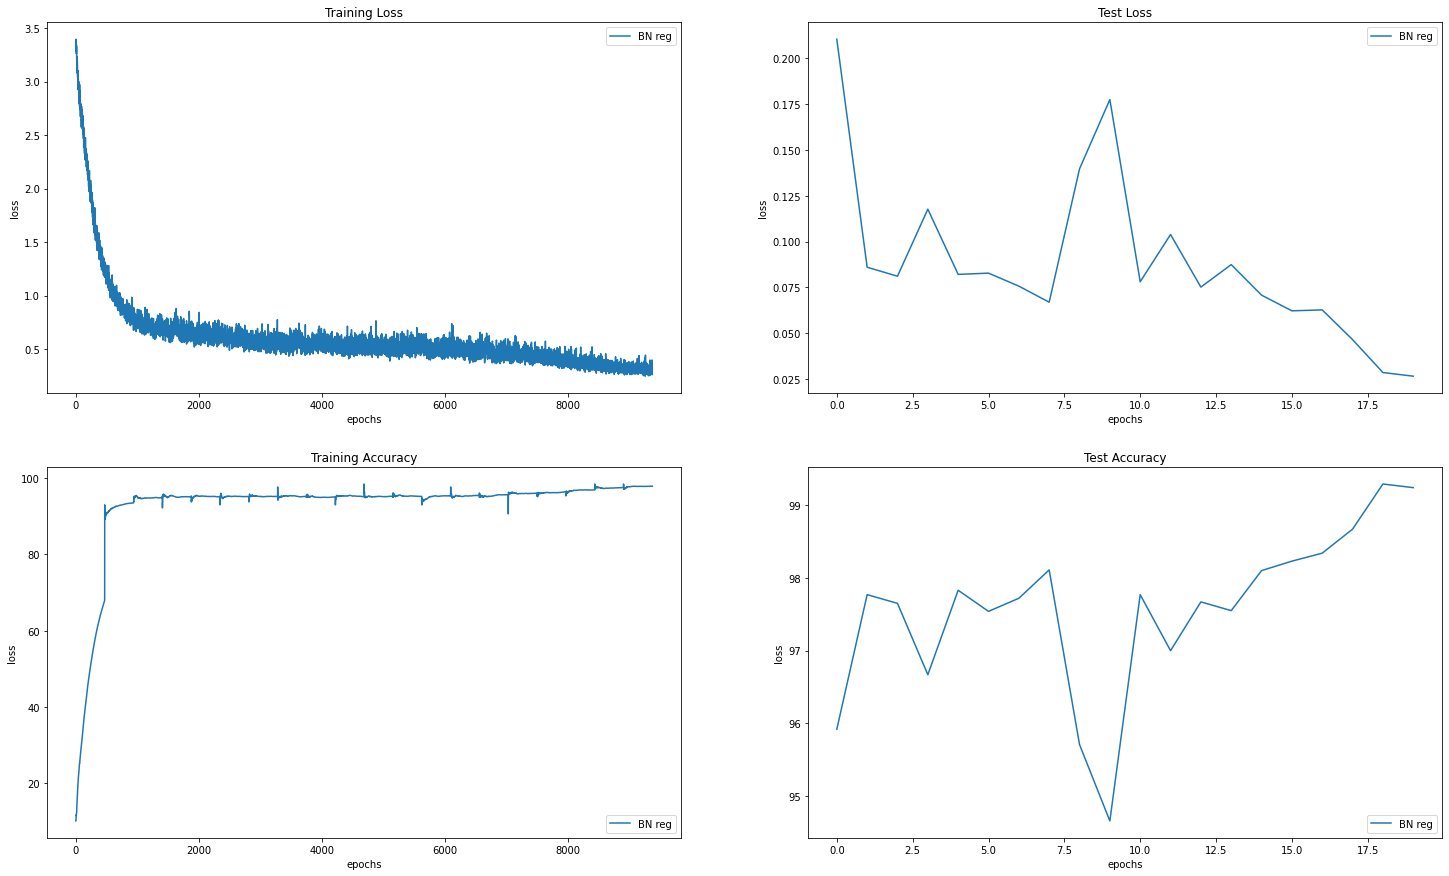

In [13]:
plot_metrics(exp_metrics)

In [14]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 